### Value

Value investing and factors depend on the "fundamental" value of a company. The *fundamental value* of a company can be seen to represent the actual worth of a company. Historically, it has been seen that a company's value relative to it's stock price has been a significant explanatory explainer for cross-sectional returns.

In our database, we have access to the following factors:
- `P/S`: Price-to-sales
- `EV/EBITDA`: Enterprise Value / EBITDA
- `P/E`: Price-to-earnings
- `EV/EBIT`: Enterprise Value / EBIT
- `P/B`: Price-to-book 

#### Per-factor cross-sectional ranking

We begin by considering the performance of cross-sectional (that is, per-month) ranking predictive for each of our factors. Value factors are sensitive to sectors - this is due to the fact that at a fundamental level, companies are valued on the basis of their sector and/or comparables.

This means that any value factor we use should be "sector-neutralised".

In [2]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
from cycler import cycler

plt.style.use("dark_background")

load_dotenv('../.env')

db_url = os.getenv('DB_URL')
psql = create_engine(db_url)

In [4]:
# eom value factors
value_factors = pd.read_sql(
    """
    select * from factor_scores
    where factor in ('PS', 'EVEBITDA', 'PE', 'EVEBIT', 'PB')
    """,
    psql
)

# monthly pricing data
price_data = pd.read_sql(
    """
    select * from eom_prices
    """,
    psql
)

# get required returns data
price_data = price_data.sort_values(['ticker', 'date'])
price_data['return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.pct_change())
price_data['t_plus_3_return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.shift(-3) / x - 1)

# constituent data for our russell 1000 proxy
monthly_constituents = pd.read_sql(
    """
    select * from monthly_constituents
    """,
    psql
)

In [5]:
# change to a wide format
wide_value_factors = value_factors.pivot_table(
    index = ['date', 'ticker'],
    columns = 'factor',
    values = 'score'
).reset_index()

value_data = price_data.merge(wide_value_factors, how='left', on=['date', 'ticker']).dropna()
value_data = value_data.merge(monthly_constituents, how='left', on=['date', 'ticker']).dropna()

value_data['date'] = pd.to_datetime(value_data['date'])

For each factor, consider the Spearman rank correlation with the 3-month forward return. We should first consider which direction we expect the factors to predict in - that is, do we expect the factors to be positively or negatively correlated with rank.

All of our above factors should see *negative* correlation, *if the hypothesis that undervalued stocks perform better in a forward 3-month return*. For example, `P/E` expresses the value of the stock relative to the earnings of the stocks. Therefore a *lower* `P/E` should expect to see a higher forward return.

We will flip our sector-neutralised factors for presentation purposes, and such that all factors in our database have `> 0` being positive expected returns.

In [7]:
from scipy.stats import zscore

# not needed if i have already computed the scores and i have centered them
# i dropped the eom factors due to some overwriting.
factors = ['EVEBIT', 'EVEBITDA', 'PB', 'PE', 'PS']

# value_centered = value_data.copy()
# value_centered[factors] = -value_centered.groupby(['date', 'sector'])[factors].transform(zscore)

In [9]:
cross_sectional_rank_ics = []

for date, data_for_date in value_data.groupby('date'):
    for factor in factors:
        cross_sectional_rank_ics.append({
            'date': date,
            'factor': factor,
            'rank_ic': data_for_date[factor].corr(data_for_date['t_plus_3_return'], method='spearman')
        })

rank_ic_df = pd.DataFrame(cross_sectional_rank_ics)

# now get rolling rank ics
rank_ic_df = rank_ic_df.sort_values(['factor', 'date'])
rank_ic_df['rolling_rank_ic'] = (
    rank_ic_df
        .groupby('factor')['rank_ic']
        .transform(lambda x: x.rolling(window=60).mean())
)

# we also get the rolling t-stat
def rolling_tstat(x, window=60):
    mean = x.rolling(window, min_periods=window).mean()
    std = x.rolling(window, min_periods=window).std()
    return mean / (std / np.sqrt(window))

rank_ic_df['rolling_ic_tstat'] = (
    rank_ic_df
        .groupby('factor')['rank_ic']
        .transform(rolling_tstat)
)

rank_ic_df = rank_ic_df.dropna()

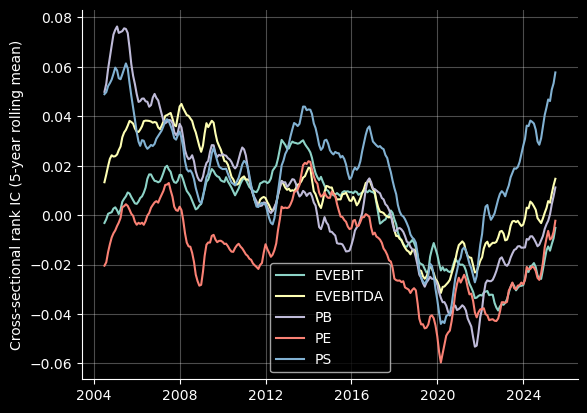

In [10]:
for factor in factors:
    factor_data = rank_ic_df[rank_ic_df['factor'] == factor]
    plt.plot(factor_data['date'], factor_data['rolling_rank_ic'], label=factor)
    plt.grid(alpha=0.3)

plt.legend()
plt.ylabel('Cross-sectional rank IC (5-year rolling mean)')
sns.despine()

We can observe that pre-2018, that most of the factors (besides `P/E`) showed moderate strength in predicting the ranking of forward T+3 returns.

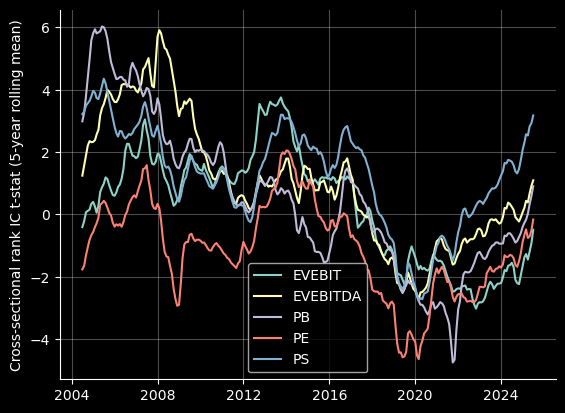

In [11]:
for factor in factors:
    factor_data = rank_ic_df[rank_ic_df['factor'] == factor]
    plt.plot(factor_data['date'], factor_data['rolling_ic_tstat'], label=factor)
    plt.grid(alpha=0.3)

plt.legend()
plt.ylabel('Cross-sectional rank IC t-stat (5-year rolling mean)')
sns.despine()

And factors show statistical significance through differing degres within the testing window. We then consider a composite factor which takes the mean across all of our factors, to consider a more simple interpretation of 'value'.

In [101]:
value_centered['value_composite'] = value_centered[factors].mean(axis=1)

# re-normalise for interpretability
value_centered['value_composite'] = value_centered.groupby('date')['value_composite'].transform(zscore)

In [113]:
composite_rank_ic = []

for date, data_for_date in value_centered.groupby('date'):
    composite_rank_ic.append({
        'date': date,
        'rank_ic': data_for_date['value_composite'].corr(data_for_date['t_plus_3_return'], method='spearman')
    })

composite_ic_df = pd.DataFrame(composite_rank_ic)
composite_ic_df = composite_ic_df.sort_values('date')
composite_ic_df['rolling_rank_ic'] = composite_ic_df['rank_ic'].rolling(window=12).mean()
composite_ic_df = composite_ic_df.dropna()

Text(0, 0.5, 'Cross-sectional rank IC (1-year rolling mean)')

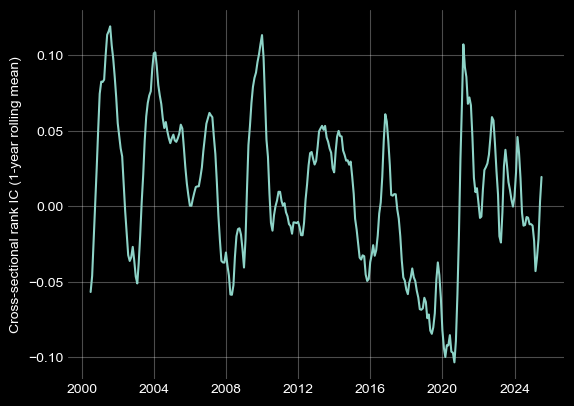

In [114]:
plt.plot(composite_ic_df['date'], composite_ic_df['rolling_rank_ic'])
plt.grid(alpha=0.3)
plt.ylabel('Cross-sectional rank IC (1-year rolling mean)')

And the composite score shows some promise too. For our modelling, we will use all of the factors; mainly because we just don't have many factors to necessitate the usage of composite means.

In [126]:
to_save_value_factors = value_centered[['date', 'ticker'] + factors]
to_save_value_factors = to_save_value_factors.melt(
    id_vars = ['ticker', 'date'],
    value_vars = factors,
    var_name = 'factor'
)
to_save_value_factors['factor'] = to_save_value_factors['factor'].str.upper()
to_save_value_factors = to_save_value_factors.rename(columns={'value': 'score'})

In [127]:
# only run this below if you have yet to save the factors
# to_save_value_factors.to_sql('factor_scores', psql, if_exists='append', index=False)

505